# Data 512 Project Part 1 - Common Analysis

In this section of the project we will be analyzing wildfire data in the context of our assigned city. My assigned city is Savannah, GA.

### Data Acquisition
We get our GeoJson data from https://www.sciencebase.gov/catalog/item/61aa537dd34eb622f699df81 and parse it using the geojson and pyproj libraries.

### Create Fire Smoke Estimates
We will use a custom metric to calculate the yearly smoke estimate for fires near Savannah, GA. We will restrict the data to fires as early as 1961 and fires within 650 miles of the city. The custom smoke metric we will use calculated as such: Smoke Estimate = (Acres Burned) / (Distance from city)^2. A more detailed breakdown of this metric can be found in the README. In a later step, we will compare this estimate to EPA air quality data.

### Visualize aspects of your Analysis
We will generate 3 sets of visualizations. The first one is a histogram showing the number of fires occurring every 50 mile distance from Savannah for all fires ranging up to 1800 miles away from the city. The next is a time series graph of total acres burned per year for the fires occurring in the specified distance (650 miles) from the city. And lastly, we will produce a time series graph containing the fire smoke estimates for the city and the AQI estimates for the city.

In [1]:
#
#    IMPORTS
# 

import os, json, time
import requests
import pandas as pd
import matplotlib.pyplot as plt

!pip install pyproj
from pyproj import Transformer, Geod

!pip install geojson
import geojson

!pip install prophet
from prophet import Prophet


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Step 0: Data Acquisition
All of the code for Step 0 is borrowed from the epa_air_quality_history_example notebook which was provided to us as a guide.

In [ ]:
#
#    CONSTANTS
#

#
#    The 'Wildfire_short_sample_2024.json' is an extraction from the full 'USGS_Wildland_Fire_Combined_Dataset.json'
#    dataset extracting several major wildfires in California, plus a couple others that have interested data structure
#    features. 
#
#    The sample file includes data for 15 fires, mostly oriented around the uniqueness of the name. Naming conventions
#    for wildfires is really adhoc, which makes finding any named fire in the dataset a disambiguation mess. The named
#    fires were selected from https://en.wikipedia.org/wiki/List_of_California_wildfires
#
#    The point nof the sample is to provide something small to test with before committing to processing the, much 
#    larger, full dataset.
#
# EXTRACT_FILENAME = "Wildfire_short_sample_2024.json"
EXTRACT_FILENAME = "USGS_Wildland_Fire_Combined_Dataset.json"
#
#    The user module 'wildfire' contains a Reader object and the sample data. This bit of code finds where that is
#    located on your machine and constructs a path so that the sample data can be loaded. This assumes you have set 
#    a PYTHONPATH environment variable to point to the location on your machine where you store python user modules.
#
#    NOTE: if you use Anaconda for virtual python environments, Anaconda will adhere to the PYTHONPATH conventions
#    for user modules.
#
MODULENAME = "wildfire"
MODULEPATH = ""
try:
    ppath = os.environ.get('PYTHONPATH')
    if not ppath: raise
    MODULEPATH = os.path.join(ppath,MODULENAME)
except:
    # Likely here because a PYTHONPATH was not set, show a warning message
    print("Looks like you're not using a 'PYTHONPATH' to specify the location of your python user modules.")
    print("You may have to modify the sample code in this notebook to get the documented behaviors.")
    MODULEPATH = "wildfire"

if MODULEPATH:
    SAMPLE_DATA_FILENAME = os.path.join(MODULEPATH,EXTRACT_FILENAME)
else:
    SAMPLE_DATA_FILENAME = EXTRACT_FILENAME
#
# print out where we think we're going to find the sample data
print(f"{SAMPLE_DATA_FILENAME=}")

#
#    A dictionary of some city locations from the US west coast states.
#
CITY_LOCATIONS = {
    'anchorage' :     {'city'   : 'Anchorage',
                       'latlon' : [61.2176, -149.8997] },
    'ocean_shores' :  {'city'   : 'Ocean Shores',    
                       'latlon' : [47.0074, -124.1614] },
    'seaside' :       {'city'   : 'Seaside',
                       'latlon' : [45.9932, -123.9226] }, 
    'bend' :          {'city'   : 'Bend',
                       'latlon' : [44.0582, -121.3153] }, 
    'medford' :       {'city'   : 'Medford',
                       'latlon' : [42.3265, -122.8756] }, 
    'crescent_city' : {'city'   : 'Crescent City',
                       'latlon' : [41.7558, -124.2026] }, 
    'tomales' :       {'city'   : 'Tomales',
                       'latlon' : [38.2411, -122.9033] }, 
    'barstow' :       {'city'   : 'Barstow',
                       'latlon' : [34.8958, -117.0173] }, 
    'redding' :       {'city'   : 'Redding',
                       'latlon' : [40.5865, -122.3916] }, 
    'encinitas' :     {'city'   : 'Encinitas',
                       'latlon' : [33.0370, -117.2920] },
    'savannah' :      {'city'   : 'Savannah',
                       'latlon' : [32.00, -81.15] }
}


In [ ]:
#
#    Open a file, load it with the geojson loader
#
print(f"Attempting to open '{SAMPLE_DATA_FILENAME}'")
geojson_file = open(SAMPLE_DATA_FILENAME,"r")
print(f"Using GeoJSON module to load sample file '{SAMPLE_DATA_FILENAME}'")
gj_data = geojson.load(geojson_file)
geojson_file.close()
#
#    Print the keys from the object
#
gj_keys = list(gj_data.keys())
print("The loaded JSON dictionary has the following keys:")
print(gj_keys)
print()
#
#    For all GeoJSON type things, the most important part of the file are the 'features'. 
#    In the case of the wildfire dataset, each feature is a polygon (ring) of points that define the bounary of a fire
#
count = len(gj_data['features'])
print(f"Found {count} features in the variable 'gj_data' ")
#

In [ ]:
#
#    First create a geodesic model that will be used for the calculations. There are a number of
#    different models of the earth. The WSG84 is one that is commonly used and relatively up-to-date
#
#geodcalc = Geod(ellps='clrk66')       # Use Clarke 1866 ellipsoid representation of the earth
geodcalc = Geod(ellps='WGS84')         # Use WGS84 ellipsoid representation of the earth

#    Two constants for accessing the 'latlon' array in our CITY_LOCATIONS constant dict
LAT = 0
LON = 1
#    Get a city from our CITY_LOCATIONS constant as our starting position
start_at = CITY_LOCATIONS["savannah"]

#    Loop through all of the cities to calculate the distance from the starting position
for city_key in CITY_LOCATIONS.keys():
    #    City destination
    destination = CITY_LOCATIONS[city_key]
    #    Note that the 'inv()' function wants coordinates in Longitude,Latitude order by default
    #    inv() also allows lat and lon parameters to be vectors/arrays - in which case the results would be vector/arrarys
    distance = geodcalc.inv(start_at['latlon'][LON],start_at['latlon'][LAT],destination['latlon'][LON],destination['latlon'][LAT])
    #    The 'distance' result variable is a tuple/list with the first two items reflecting forward/backward azimuths
    #    and the third item representing the distance in meters. 
    d_meters = distance[2]
    d_miles = d_meters * 0.00062137 # constant to convert meters to miles
    #    BTW, this isn't actually a 'straight' line because the whole reason for using pyproj is to calculate
    #    these distance measures over the surface of a sphere/ellipsoid. We set up which ellipsoid to use when we
    #    defined the 'geodcalc' object near the top of this cell
    print(f"Straight line distance from {start_at['city']} to {destination['city']} is {d_meters} meters or {d_miles:5.2f} miles")



In [ ]:
#
#    Transform feature geometry data
#
#    The function takes one parameter, a list of ESRI:102008 coordinates that will be transformed to EPSG:4326
#    The function returns a list of coordinates in EPSG:4326
def convert_ring_to_epsg4326(ring_data=None):
    converted_ring = list()
    #
    # We use a pyproj transformer that converts from ESRI:102008 to EPSG:4326 to transform the list of coordinates
    to_epsg4326 = Transformer.from_crs("ESRI:102008","EPSG:4326")
    # We'll run through the list transforming each ESRI:102008 x,y coordinate into a decimal degree lat,lon
    for coord in ring_data:
        lat,lon = to_epsg4326.transform(coord[0],coord[1])
        new_coord = lat,lon
        converted_ring.append(new_coord)
    return converted_ring

In [ ]:
#
#   Convert one ring from the default to EPSG
#
#   There are two options here - depending upon whether you loaded data useing GeoJSON or the wildfire.Reader
#
ring_in_epsg4326 = convert_ring_to_epsg4326(gj_bigest_ring)
#
# ring_in_epsg4326 = convert_ring_to_epsg4326(wf_bigest_ring)
#
print(f"Ring consists of {len(ring_in_epsg4326)} points.")
#
#    If you want to print them out you can see what they look like converted.
#print(ring_in_epsg4326)
#for point in ring_in_epsg4326:
#    print(f"{point[0]},{point[1]}")

In [ ]:
#    
#    The function takes two parameters
#        A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
#        Ring_data - a list of decimal degree coordinates for the fire boundary
#
#    The function returns a list containing the shortest distance to the perimeter and the point where that is
#
def shortest_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)    
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    closest_point = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        # convert the distance to miles
        distance_in_miles = d[2]*0.00062137
        # if it's closer to the city than the point we have, save it
        if not closest_point:
            closest_point.append(distance_in_miles)
            closest_point.append(point)
        elif closest_point and closest_point[0]>distance_in_miles:
            closest_point = list()
            closest_point.append(distance_in_miles)
            closest_point.append(point)
    return closest_point



#    
#    The function takes two parameters
#        A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
#        Ring_data - a list of decimal degree coordinates for the fire boundary
#
#    The function returns the average miles from boundary to the place
#
def average_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)    
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    # create a list to store our results
    distances_in_meters = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        distances_in_meters.append(d[2])
    #print("Got the following list:",distances_in_meters)
    # convert meters to miles
    distances_in_miles = [meters*0.00062137 for meters in distances_in_meters]
    # the esri polygon shape (the ring) requires that the first and last coordinates be identical to 'close the region
    # we remove one of them so that we don't bias our average by having two of the same point
    distances_in_miles_no_dup = distances_in_miles[1:]
    # now, average miles
    average = sum(distances_in_miles_no_dup)/len(distances_in_miles_no_dup)
    return average


This code iterates through the full wildfire dataset and extracts the fires that are 1800 miles or closer from Savannah, GA. These entries are loaded into a dataframe and saved to the parsed_data csv file so they can be easily loaded afterwards. 

NOTE: This code takes a long time to run and the output file (parsed_data.csv) has already been generated for use in the later steps.

In [ ]:
place = CITY_LOCATIONS["savannah"]

parsed_df = pd.DataFrame({
    "id": [],
    "year": [],
    "size": [],
    "distance": []
})

for wf_feature in feature_list:    
    wf_id = wf_feature['attributes']['USGS_Assigned_ID']
    wf_year = wf_feature['attributes']['Fire_Year']
    wf_size = wf_feature['attributes']['GIS_Acres']
    
    if 'rings' in wf_feature['geometry']:
        ring_data = wf_feature['geometry']['rings'][0]
    elif 'curveRings' in wf_feature['geometry']:
        ring_data = wf_feature['geometry']['curveRings'][0]
    else:
        raise Exception("HEY! No compatible geometry in this fire data!!!")
        
    try:
        distance = average_distance_from_place_to_fire_perimeter(place['latlon'], ring_data)
        if distance <= 1800:
            parsed_df.loc[len(parsed_df)] = [wf_id, wf_year, wf_size, distance]
    except:
        print("Exception")
    
parsed_df.to_csv("parsed_data.csv", index=False)
print("FINISHED")

# Step 1: Create Fire Smoke Estimates

To estimate the smoke of a fire, we use 2 variables: size (acres of wildfire) and distance (distance from the city). Smoke disperses as a function of the square of distance and the amount of smoke scales as a function of surface area. Putting this together we get our naive smoke estimate: Smoke Estimate = Size / (Distance^2).

In [19]:
df = pd.read_csv("parsed_data.csv")
df['distance'] = df['distance'].astype(int)

df_savannah = df[(df['year'] >= 1961) & (df['distance'] <= 650)]
df_savannah['smoke_estimate'] = df_savannah['size'] / (df['distance'] ** 2)

df_smoke_totals = df_savannah.groupby('year')['smoke_estimate'].sum().reset_index()

C:\Users\ashwi\AppData\Local\Temp\ipykernel_18276\2129368431.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_savannah['smoke_estimate'] = df_savannah['size'] / (df['distance'] ** 2)


To help capture the the trends in this data, we will be using the prophet modeling library. We will plot the historic smoke estimates using the metric and the predicted smoke estimates for 2025-2050.

23:18:18 - cmdstanpy - INFO - Chain [1] start processing
23:18:18 - cmdstanpy - INFO - Chain [1] done processing


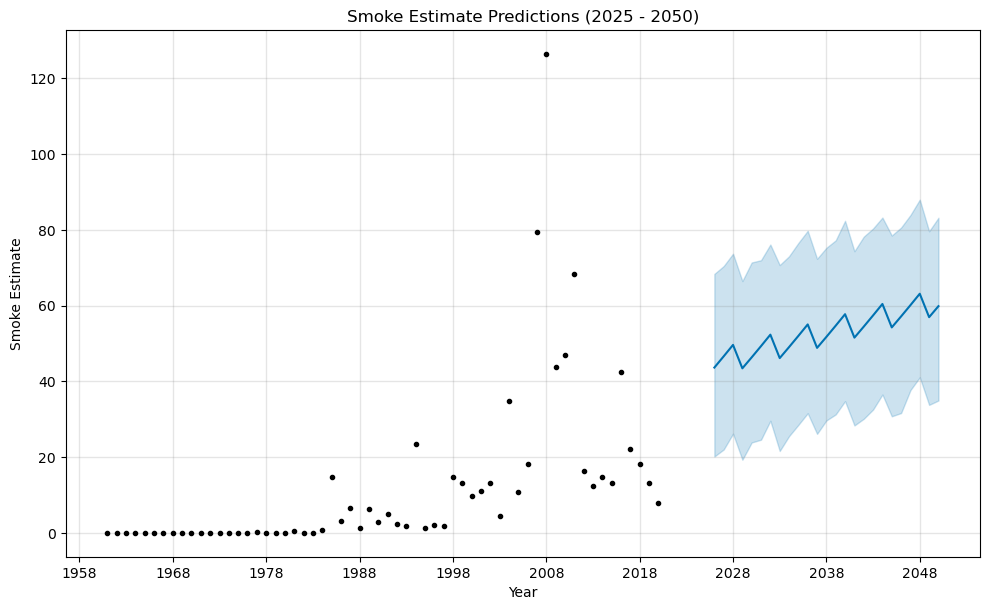

In [20]:
# Prophet requires a specific naming convention for the columns
df_prophet = df_smoke_totals.rename(columns={'year': 'ds', 'smoke_estimate': 'y'})
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format='%Y')

# Fit the model
model = Prophet()
model.fit(df_prophet)

# Make the predictions
future_years = pd.DataFrame({'ds': pd.date_range(start='2025', end='2050', freq='Y')})
forecast = model.predict(future_years)

# Plot the results
fig = model.plot(forecast)
plt.title("Smoke Estimate Predictions (2025 - 2050)")
plt.xlabel("Year")
plt.ylabel("Smoke Estimate")
plt.show()


# Step 2: Visualize aspects of your Analysis

In this step, we will create a series of visualizations to better understand the wilfire situation around Savannah, GA.

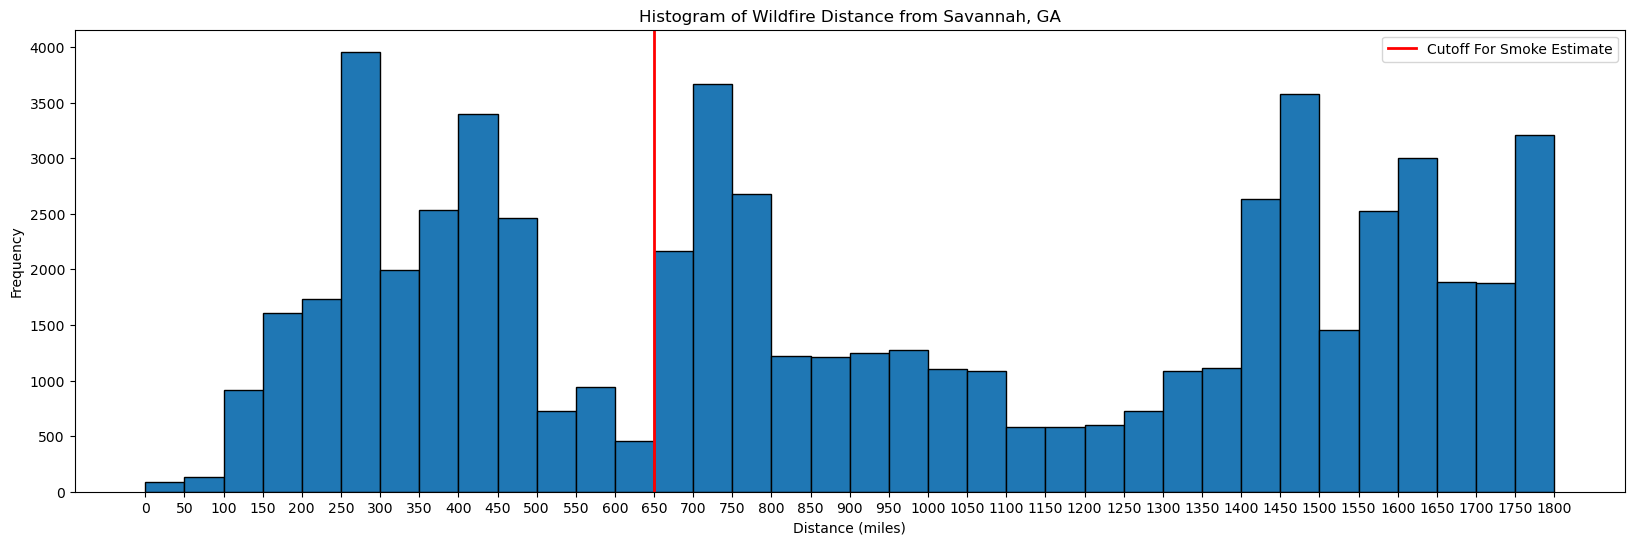

In [21]:
# Histogram showing the number of fires occurring every 50 mile 
# distance from Savannah, GA for all fires ranging up to 1800 miles 
# away from the city.

plt.figure(figsize=(20, 6))
plt.hist(df['distance'], bins=range(0, df['distance'].max() + 50, 50), edgecolor='black')
plt.title("Histogram of Wildfire Distance from Savannah, GA")
plt.xlabel("Distance (miles)")
plt.ylabel("Frequency")
plt.xticks(range(0, df['distance'].max() + 50, 50))
plt.axvline(x=650, color='red', linestyle='-', linewidth=2, label="Cutoff For Smoke Estimate")
plt.legend()


# Display the plot
plt.show()

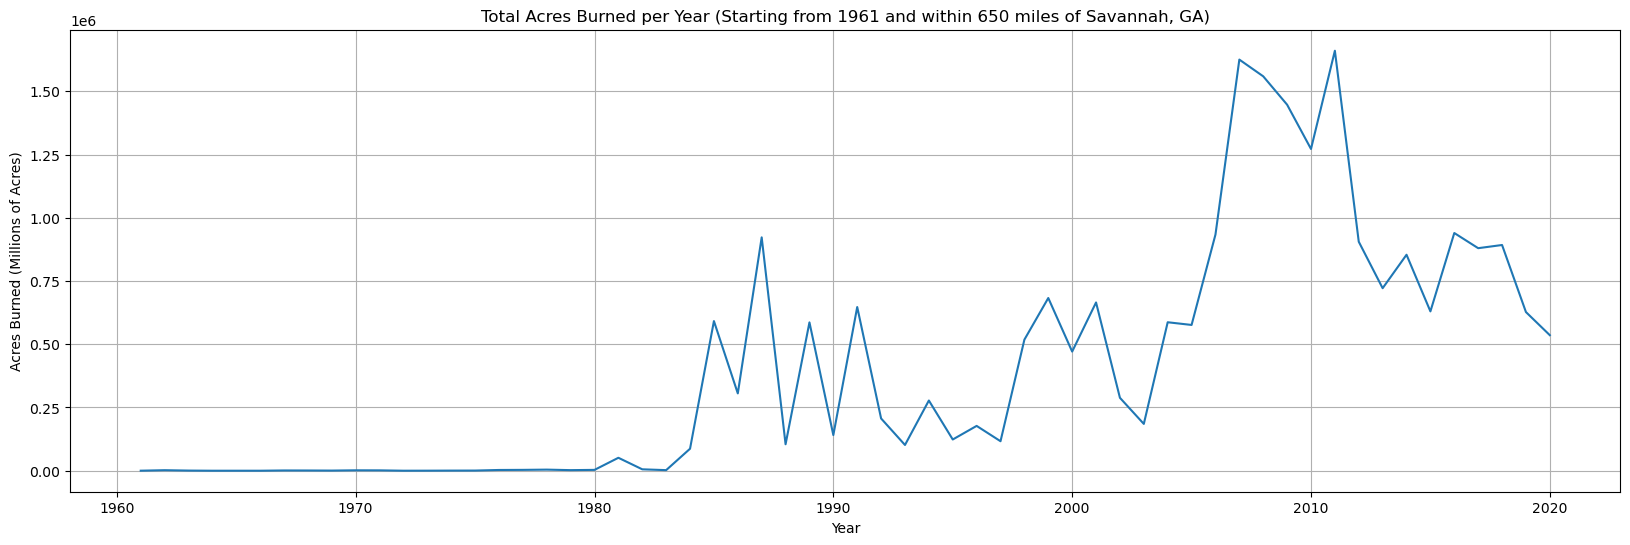

In [22]:
# Time series graph of total acres burned per year for 
# the fires occurring in the specified distance (<= 650 miles)
# from Savannah, GA.

df_acres_burned = df_savannah.groupby('year')['size'].sum().reset_index()

plt.figure(figsize=(20, 6))
plt.plot(df_acres_burned['year'], df_acres_burned['size'])
plt.title("Total Acres Burned per Year (Starting from 1961 and within 650 miles of Savannah, GA)")
plt.xlabel("Year")
plt.ylabel("Acres Burned (Millions of Acres)")
plt.grid(True)

# Display the plot
plt.show()

Now we want to take a look at the AQI (Air Quality Index) metric from the EPA. Most of the code used here is borrowed from the epa_air_quality_history_example notebook that was provided for us.

In [2]:
#########
#
#    CONSTANTS
#

#
#    This is the root of all AQS API URLs
#
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

#
#    These are some of the 'actions' we can ask the API to take or requests that we can make of the API
#
#    Sign-up request - generally only performed once - unless you lose your key
API_ACTION_SIGNUP = '/signup?email={email}'
#
#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'
#
#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    Summary actions are requests for summary data. These are for daily/annual summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    It is always nice to be respectful of a free data resource.
#    We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
#
#
#    This is a template that covers most of the parameters for the actions we might take, from the set of actions
#    above. In the examples below, most of the time parameters can either be supplied as individual values to a
#    function - or they can be set in a copy of the template and passed in with the template.
# 
AQS_REQUEST_TEMPLATE = {
    "email":      "",     
    "key":        "",      
    "state":      "",     # the two digit state FIPS # as a string
    "county":     "",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}



In [3]:
#
#    This implements the sign-up request. The parameters are standardized so that this function definition matches
#    all of the others. However, the easiest way to call this is to simply call this function with your preferred
#    email address.
#
def request_signup(email_address = None,
                   endpoint_url = API_REQUEST_URL, 
                   endpoint_action = API_ACTION_SIGNUP, 
                   request_template = AQS_REQUEST_TEMPLATE,
                   headers = None):
    
    # Make sure we have a string - if you don't have access to this email addres, things might go badly for you
    if email_address:
        request_template['email'] = email_address        
    
    if not request_template['email']: 
        raise Exception("Must supply an email address to call 'request_signup()'")

    if '@' not in request_template['email']: 
        raise Exception(f"Must supply an email address to call 'request_signup()'. The string '{request_template['email']}' does not look like an email address.")

    # Compose the signup url - create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

For security purposes, the API Key I used is not included in this notebook.

In [4]:
#
#    A SIGNUP request is only to be done once, to request a key. A key is sent to that email address and needs to be confirmed with a click through
#    This code should probably be commented out after you've made your key request to make sure you don't accidentally make a new sign-up request
#
#print("Requesting SIGNUP ...")
#USERNAME = "ashwin19@uw.edu"
#response = request_signup(USERNAME)
#print(json.dumps(response,indent=4))
#
# KEY: 
USERNAME = "ashwin19@uw.edu"
APIKEY = # Fill in the API KEY

In [5]:
#
#   Given the set of sensor codes, now we can create a parameter list or 'param' value as defined by the AQS API spec.
#   It turns out that we want all of these measures for AQI, but we need to have two different param constants to get
#   all seven of the code types. We can only have a max of 5 sensors/values request per param.
#
#   Particulate AQI pollutants PM10, PM2.5, and Acceptable PM2.5
AQI_PARAMS_PARTICULATES = "81102,88101,88502"
#   
#

In [6]:
CITY_LOCATIONS = {
    'savannah' :       {'city'   : 'Savannah',
                       'county' : 'Chatham',
                       'state'  : 'Georgia',
                       'fips'   : '13051',
                       'latlon' : [32.00, -81.15]}
}

In [7]:
#
#    This implements the daily summary request. Daily summary provides a daily summary value for each sensor being requested
#    from the start date to the end date. 
#
#    Like the two other functions, this can be called with a mixture of a defined parameter dictionary, or with function
#    parameters. If function parameters are provided, those take precedence over any parameters from the request template.
#
def request_daily_summary(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_DAILY_SUMMARY_COUNTY, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
    # Note we're not validating FIPS fields because not all of the daily summary actions require the FIPS numbers
        
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

In [8]:
#
#    This is a list of field names - data - that will be extracted from each record
#
EXTRACTION_FIELDS = ['sample_duration','observation_count','arithmetic_mean','aqi']

#
#    The function creates a summary record
def extract_summary_from_response(r=None, fields=EXTRACTION_FIELDS):
    ## the result will be structured around monitoring site, parameter, and then date
    result = dict()
    data = r["Data"]
    for record in data:
        # make sure the record is set up
        site = record['site_number']
        param = record['parameter_code']
        #date = record['date_local']    # this version keeps the respnse value YYYY-
        date = record['date_local'].replace('-','') # this puts it in YYYYMMDD format
        if site not in result:
            result[site] = dict()
            result[site]['local_site_name'] = record['local_site_name']
            result[site]['site_address'] = record['site_address']
            result[site]['state'] = record['state']
            result[site]['county'] = record['county']
            result[site]['city'] = record['city']
            result[site]['pollutant_type'] = dict()
        if param not in result[site]['pollutant_type']:
            result[site]['pollutant_type'][param] = dict()
            result[site]['pollutant_type'][param]['parameter_name'] = record['parameter']
            result[site]['pollutant_type'][param]['units_of_measure'] = record['units_of_measure']
            result[site]['pollutant_type'][param]['method'] = record['method']
            result[site]['pollutant_type'][param]['data'] = dict()
        if date not in result[site]['pollutant_type'][param]['data']:
            result[site]['pollutant_type'][param]['data'][date] = list()
        
        # now extract the specified fields
        extract = dict()
        for k in fields:
            if str(k) in record:
                extract[str(k)] = record[k]
            else:
                # this makes sure we always have the requested fields, even if
                # we have a missing value for a given day/month
                extract[str(k)] = None
        
        # add this extraction to the list for the day
        result[site]['pollutant_type'][param]['data'][date].append(extract)
    
    return result


This code block iterates through the AQI data for particulates from 1986 (The earliest data we can access) to 2021 and records the data in a data frame which we save to a file (parsed_aqi_data.csv). This output file has already been created and is ready for use in the next section.

In [11]:
aqi_df = pd.DataFrame({
    "year": [],
    "aqi": []
})

for year in range(1986, 2022):
    request_data = AQS_REQUEST_TEMPLATE.copy()
    request_data['email'] = USERNAME
    request_data['key'] = APIKEY
    request_data['state'] = CITY_LOCATIONS['savannah']['fips'][:2]
    request_data['county'] = CITY_LOCATIONS['savannah']['fips'][2:]
    request_data['param'] = AQI_PARAMS_PARTICULATES

    # request daily summary data for a given year's fire season
    particulate_aqi = request_daily_summary(request_template=request_data, begin_date=str(year)+"0501", end_date=str(year)+"1031")
    if particulate_aqi["Header"][0]['status'] == "Success":
        print(year)
        extract_particulate = extract_summary_from_response(particulate_aqi)
        
        date_range = pd.date_range(start=str(year)+"-05-01", end=str(year)+"-10-31")
        date_strings = date_range.strftime('%Y%m%d').tolist()
        
        for date in date_strings:
            pollutant_data = extract_particulate['1002']['pollutant_type']
            aqi_data = pollutant_data[next(iter(pollutant_data))]['data']
            if date in aqi_data:
                aqi_data_array = aqi_data[date]
                for entry in aqi_data_array:
                    aqi = entry['aqi']
                    aqi_df.loc[len(aqi_df)] = [year, aqi]

aqi_df.to_csv("parsed_aqi_data.csv", index=False)
print("FINISHED")
        

Response for the particulate pollutants ...
1986
Response for the particulate pollutants ...
1987
Response for the particulate pollutants ...
1988
Response for the particulate pollutants ...
1989
Response for the particulate pollutants ...
1990
Response for the particulate pollutants ...
1991
Response for the particulate pollutants ...
1992
Response for the particulate pollutants ...
1993
Response for the particulate pollutants ...
1994
Response for the particulate pollutants ...
1995
Response for the particulate pollutants ...
1996
Response for the particulate pollutants ...
1997
Response for the particulate pollutants ...
1998
Response for the particulate pollutants ...
1999
Response for the particulate pollutants ...
2000
Response for the particulate pollutants ...
2001
Response for the particulate pollutants ...
2002
Response for the particulate pollutants ...
2003
Response for the particulate pollutants ...
2004
Response for the particulate pollutants ...
2005
Response for the par

Next, we remove null rows and plot the aqi data to see what the spread looks like.

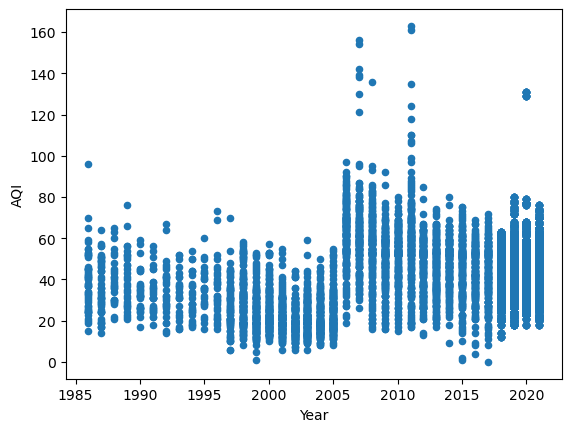

In [16]:
df_aqi = pd.read_csv("parsed_aqi_data.csv")
df_aqi_cleaned = df_aqi.dropna()

df_aqi_cleaned.plot(kind='scatter', x='year', y='aqi')
plt.title("")
plt.xlabel("Year")
plt.ylabel("AQI")
plt.show()

Like with the wildfire data, we use prophet to create a model to predict AQI values from 2025 to 2050.

23:08:46 - cmdstanpy - INFO - Chain [1] start processing
23:08:53 - cmdstanpy - INFO - Chain [1] done processing


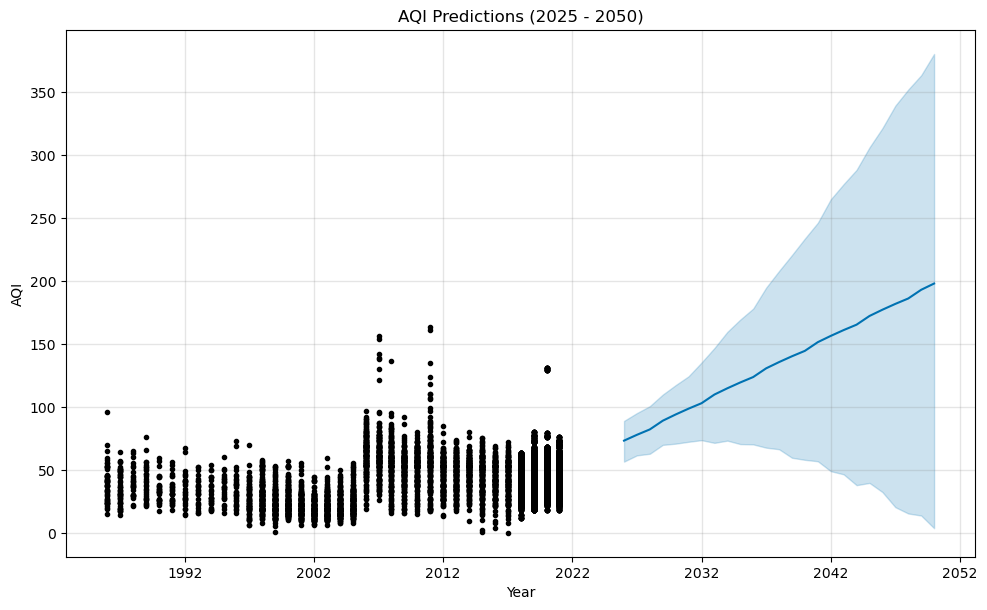

In [17]:
df_aqi_prophet = df_aqi_cleaned.rename(columns={'year': 'ds', 'aqi': 'y'})
df_aqi_prophet['ds'] = pd.to_datetime(df_aqi_prophet['ds'], format='%Y')

# Fit the model
model_aqi = Prophet()
model_aqi.fit(df_aqi_prophet)

# Make the predictions
future_years = pd.DataFrame({'ds': pd.date_range(start='2025', end='2050', freq='Y')})
forecast = model_aqi.predict(future_years)

# Plot the results
fig = model_aqi.plot(forecast)
plt.title("AQI Predictions (2025 - 2050)")
plt.xlabel("Year")
plt.ylabel("AQI")
plt.show()